# ONC API 2.0 Usage

This notebook demonstates several basic use cases of the ONC Oceans API version 2.0 for Python 3. For more information, see the [documentation](https://wiki.oceannetworks.ca/display/O2A).

***

### To run this notebook ...

I recommend installing [Miniconda](https://docs.conda.io/en/latest/miniconda.html) as your Python package manager,

(on Mac)

```
$ curl -O https://repo.anaconda.com/miniconda/Miniconda3-latest-MacOSX-x86_64.sh
$ bash Miniconda3-latest-MacOSX-x86_64.sh
```

(on Linux)

```
$ wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
$ bash Miniconda3-latest-Linux-x86_64.sh
```

setting up a virtual environment with the necessary packages,

```
$ conda create -n py3_onc -c conda-forge bottleneck cartopy dask jupyterlab netcdf4 xarray
$ conda activate py3_onc
```

installing `onc`,

```
$ pip install --upgrade pip
$ pip install onc
```

and then running `jupyterlab` from the command line.

```
$ jupyter lab
```

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, dates
from cartopy import crs, feature
from datetime import datetime, timedelta
from dateutil.parser import parse
from onc.onc import ONC

%matplotlib inline

In [2]:
# A bit of matplotlib customization
plt.rcParams['font.size'] = 12
palette = plt.get_cmap('tab10')
ncolors = palette.N - 1

***

## Basic usage

Invoke ONC using token

In [3]:
onc = ONC(
    token='YOUR_TOKEN_HERE',
    outPath='/PATH/TO/DOWNLOADS',
)

***

### Browsing data and locations

`onc.getLocations()`

In [4]:
# Print all locations with ADCP150KHZ data
filters = {'deviceCategoryCode': 'ADCP150KHZ'}
for location in onc.getLocations(filters):
    print(f"{location['locationCode']:10s}", location['locationName'])

BACME      Barkley Canyon Mid-East
BACMW      Barkley Canyon Mid-West
RVSKQ      R/V Sikuliaq
SCVIP      Strait of Georgia VENUS Instrument Platform
SEVIP      Strait of Georgia East VENUS Instrument Platform
VEC        CCGS Vector


`onc.getDeviceCategories()`

In [5]:
# Print all devices at ONC Central Node
filters = {'locationCode': 'SCVIP'}
for device in onc.getDeviceCategories(filters):
    print(f"{device['deviceCategoryCode']:20s}", device['description'])

ADCP150KHZ           Acoustic Doppler Current Profiler 150 kHz 
ADCP600KHZ           Acoustic Doppler Current Profiler 600 kHz 
CTD                  Conductivity Temperature (and Depth Sensor)
CURRENTMETER         Current Meter
ECHOSOUNDERBIOA      Echosounder, Bioacoustic
FLNTU                Fluorometer Turbidity
HYDROPHONE           Hydrophone
JB                   Junction Box
OXYSENSOR            Oxygen Sensor
PARTANALYZER         Particle Analyzer
TURBIDITYMETER       Turbidity Meter
VIDEOCAM             Video Camera


`onc.getDataProducts()`

In [6]:
# Print all data products at ONC Central Node
filters = {'locationCode': 'SCVIP', 'extension': 'nc'}
for dataproduct in onc.getDataProducts(filters):
    print(f"{dataproduct['dataProductCode']:10s}", dataproduct['dataProductName'])

CSPPD      Cast Scalar Profile Plot and Data
RADCPTS    RDI ADCP Time Series
TSSD       Time Series Scalar Data
TSSPPGD    Time Series Scalar Profile Plot and Gridded Data


`onc.getListByLocation()`

In [7]:
# Print all CTD and ADCP files available at ONC Central Node in a given range
filters = {'locationCode': 'SCVIP', 'dateFrom': '2020-08-01T00:00:00.000Z', 'dateTo': '2020-08-05T00:00:00.000Z'}
for device in ['CTD', 'ADCP150KHZ']:
    filters.update({'deviceCategoryCode': device})
    for filename in onc.getListByLocation(filters)['files']:
        print(filename)

SBECTD19p7793_20200801T000000.000Z.txt
SBECTD19p7793_20200802T000000.000Z.txt
SBECTD19p7793_20200803T000000.000Z.txt
SBECTD19p7793_20200804T000000.000Z.txt
RDIADCP150WH17457_20200801T000000.000Z.txt
RDIADCP150WH17457_20200802T000000.000Z.txt
RDIADCP150WH17457_20200803T000000.000Z.txt
RDIADCP150WH17457_20200804T000000.000Z.txt


***

### Previewing data

`onc.getDirectScalar()`

In [8]:
# Load 24 hours of Central Node CTD data into JSON format
# -- max I was able to get is about 28 hours of scalar data
# -- doesn't seem to be available for ADCP profile data
filters = {
    'locationCode': 'SCVIP',
    'deviceCategoryCode': 'CTD',
    'dateFrom': '2020-08-01T00:00:00.000Z',
    'dateTo': '2020-08-02T00:00:00.000Z',
}
data = onc.getDirectScalar(filters)

# Print sensors and list indices
for i, sensor in enumerate(data['sensorData']):
    print(f"{i:<3d}{sensor['sensorName']:25s}", sensor['unitOfMeasure'])

0  Conductivity              S/m
1  Density                   kg/m3
2  Depth                     m
3  Pressure                  decibar
4  Practical Salinity        psu
5  Sigma-t                   kg/m3
6  Sigma-theta (0 dbar)      kg/m3
7  Sound Speed               m/s
8  Temperature               C


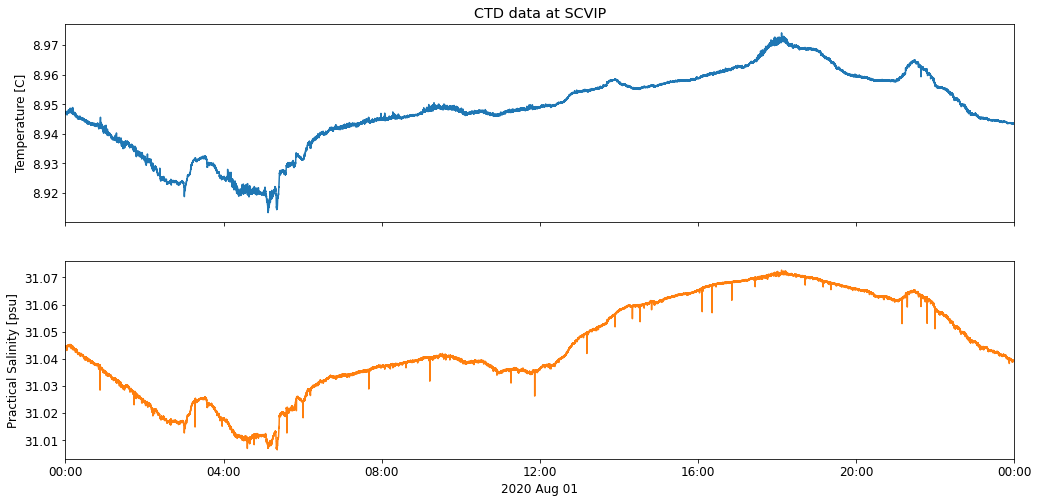

In [9]:
# Plot temperature and salinity
fig, axs = plt.subplots(2, 1, figsize=(17, 8))
daterange = [parse(data['parameters'][key]) for key in ['dateFrom', 'dateTo']]
for ax, i, k in zip(axs, [8, 4], range(2)):
    sensor = data['sensorData'][i]
    datetimes = [parse(t) for t in sensor['data']['sampleTimes']]
    ax.plot(datetimes, sensor['data']['values'], color=palette(k/ncolors))
    ax.set_xlim(daterange)
    ax.set_ylabel(f"{sensor['sensorName']} [{sensor['unitOfMeasure']}]")
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(dates.HourLocator(interval=4))
axs[0].set_title(' data at '.join(data['parameters'][key] for key in ['deviceCategoryCode', 'locationCode']))
axs[0].xaxis.set_ticklabels('')
axs[1].set_xlabel(daterange[0].strftime('%Y %b %d'))
plt.show()

***

### Downloading data

`onc.orderDataProduct()`

ADCP example. Filters will be different for e.g., CTD. For more information about filters, see the [Data Products](https://wiki.oceannetworks.ca/display/DP) section of the documentation.

In [10]:
# Filters for ONC Central Node ADCP data
# dpo parameters from https://wiki.oceannetworks.ca/display/DP/5
filters = {
    'locationCode': 'SCVIP',
    'deviceCategoryCode': 'ADCP150KHZ',
    'dataProductCode': 'RADCPTS',
    'extension': 'nc',
    'dateFrom': '2020-08-01T00:00:00.000Z',
    'dateTo': '2020-08-02T00:00:00.000Z',
    'dpo_ensemblePeriod': 900,    # Default value
    'dpo_velocityBinmapping': 2,  # Default value
    'dpo_3beam': 'Off',           # Default value
    'dpo_corScreen': 64,          # Default value
    'dpo_errVelScreen': 2,        # Default value
    'dpo_falseTarScreen': 255,    # Default value
}

# Download data
# -- may time out if maxRetries is too low
downloadDetails = onc.orderDataProduct(filters=filters, maxRetries=100, includeMetadataFile=False)

Request Id: 8967852
Estimated File Size: No estimated file size available.
Estimated Processing Time: No estimated processing time available.


   Running..
   Running... working on time segment 1 of 1, for device deployment 1 of 1................
   Transferring (StraitofGeorgiaCentral_StraitofGeorgiaVENUSInstrumentPlatform_AcousticDopplerCurrentProfiler150kHz_20200801T000000Z_20200802T000000Z-Ensemble900s_binMapLinearInterp.nc) to the FTP server........
Total run time: a moment
Total download Time: 0.132 seconds
1 files (499.0 kB) downloaded


In [11]:
# List download parameters
for item in downloadDetails['downloadResults'][0].items():
    print(f"{item[0]}:", item[1])

url: https://data.oceannetworks.ca/api/dataProductDelivery?method=download&token=76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a&dpRunId=21111391&index=1
status: complete
size: 499024
file: StraitofGeorgiaCentral_StraitofGeorgiaVENUSInstrumentPlatform_AcousticDopplerCurrentProfiler150kHz_20200801T000000Z_20200802T000000Z-Ensemble900s_binMapLinearInterp.nc
index: 1
downloaded: True
requestCount: 29
fileDownloadTime: 0.132


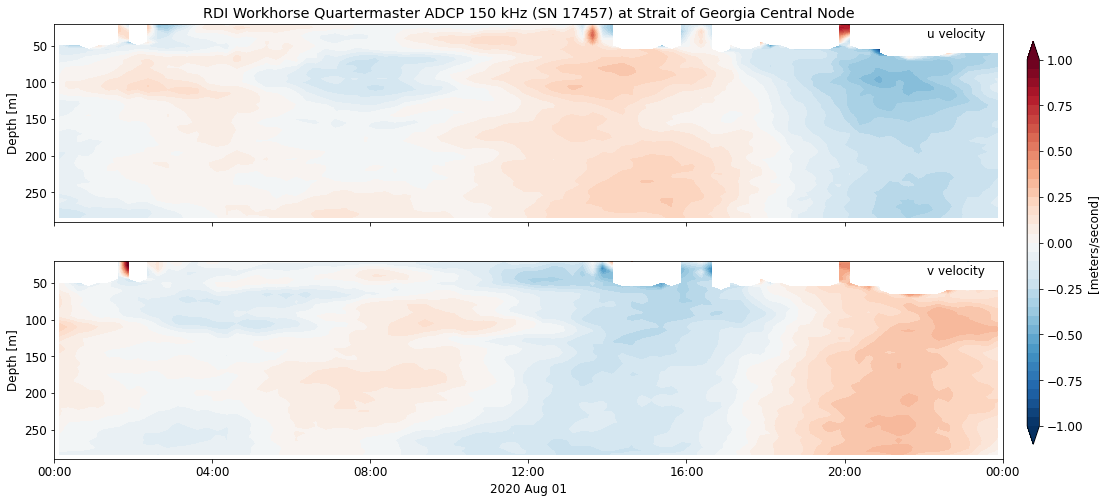

In [12]:
# Plot ADCP velocities
fig, axs = plt.subplots(2, 1, figsize=(17, 8))
daterange = [parse(filters[key]) for key in ['dateFrom', 'dateTo']]
fn = onc.outPath + '/' + downloadDetails['downloadResults'][0]['file']
with xr.open_dataset(fn) as data:
    datetimes = data.time.values.astype('datetime64[s]').astype(datetime)
    units = data.u.units
    for ax, vel in zip(axs, ['u', 'v']):
        c = ax.contourf(datetimes, data.depth, data[vel].T, levels=np.arange(-1, 1.01, 0.05), cmap='RdBu_r', extend='both')
        ax.set_xlim(daterange)
        ax.set_ylim([290, 20])
        ax.set_ylabel('Depth [m]')
        ax.text(0.92, 0.93, f"{vel} velocity", transform=ax.transAxes)
        ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(dates.HourLocator(interval=4))
axs[0].set_title(' at '.join(getattr(data, key) for key in ['device_name', 'location_name']))
axs[0].xaxis.set_ticklabels('')
axs[1].set_xlabel(daterange[0].strftime('%Y %b %d'))
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label=f"[{units}]")
plt.show()

***

## Some browsing examples

Here I look for locations with device categories using `onc.getLocations()`, and plot them on a `cartopy` map.

In [13]:
def plot_map(ax):
    """Plot map centered over Vancouver Island using Cartopy
    """
    
    ax.set_extent([-127.01, -121.99, 46.99, 51.01])
    ax.add_feature(feature.GSHHSFeature('high', edgecolor='k', facecolor='lightgray'))
    for name in ['rivers_lake_centerlines', 'rivers_north_america', 'lakes_north_america']:
        fc = 'w' if name == 'lakes_north_america' else 'none'
        ax.add_feature(feature.NaturalEarthFeature(category='physical', name=name, scale='10m', ec='k', fc=fc))
    gl = ax.gridlines(xlocs=range(-127, -121), ylocs=range(47, 52), linestyle=':', color='k', draw_labels=True)
    gl.top_labels, gl.right_labels = False, False


def plot_locations(device, color='k'):
    """Plot all platform locations with DEVICE installed using onc.getLocations()
    """
    
    # I'm using dataProductCode for ADCP to generalize all frequencies
    key = 'dataProductCode' if device == 'RADCPTS' else 'deviceCategoryCode'
    label = device
    for location in onc.getLocations({key: device}):
        coords = [location[key] for key in ('lon', 'lat')]
        if None not in coords:
            ax.plot(*coords, 'ko', mfc=color, ms=8, label=label, transform=crs.PlateCarree())
            label = None

Plot physical device platforms

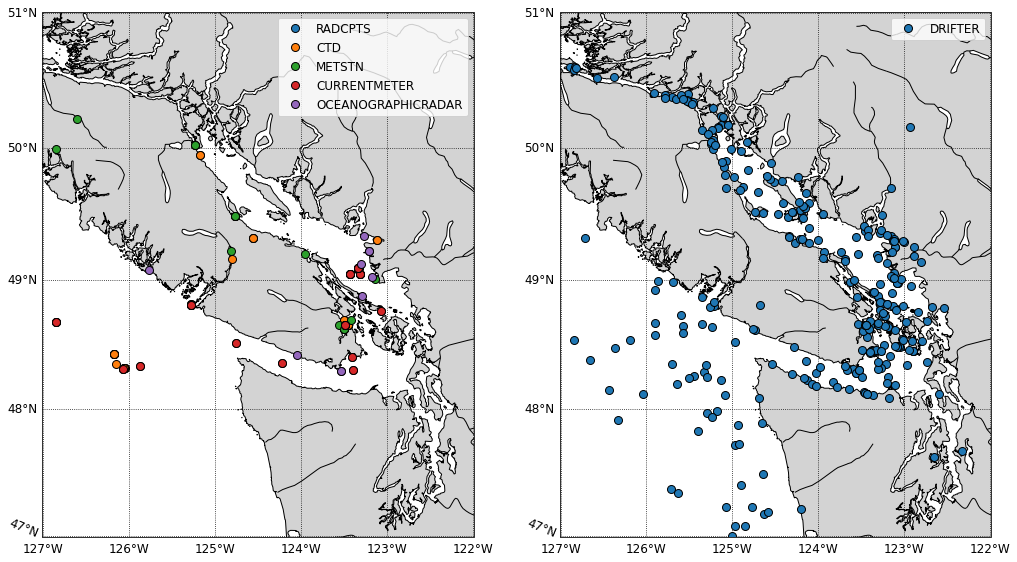

In [15]:
# Plot physical device platforms
fig, axs = plt.subplots(1, 2, figsize=(17, 10), subplot_kw={'projection': crs.Mercator()})
devices_list = [
    ['RADCPTS', 'CTD', 'METSTN', 'CURRENTMETER', 'OCEANOGRAPHICRADAR'],
    ['DRIFTER'],
]
for ax, devices in zip(axs, devices_list):
    plot_map(ax)
    for k, device in enumerate(devices):
        plot_locations(device, color=palette(k/ncolors))
    ax.legend()

Plot biological/chemical device platforms

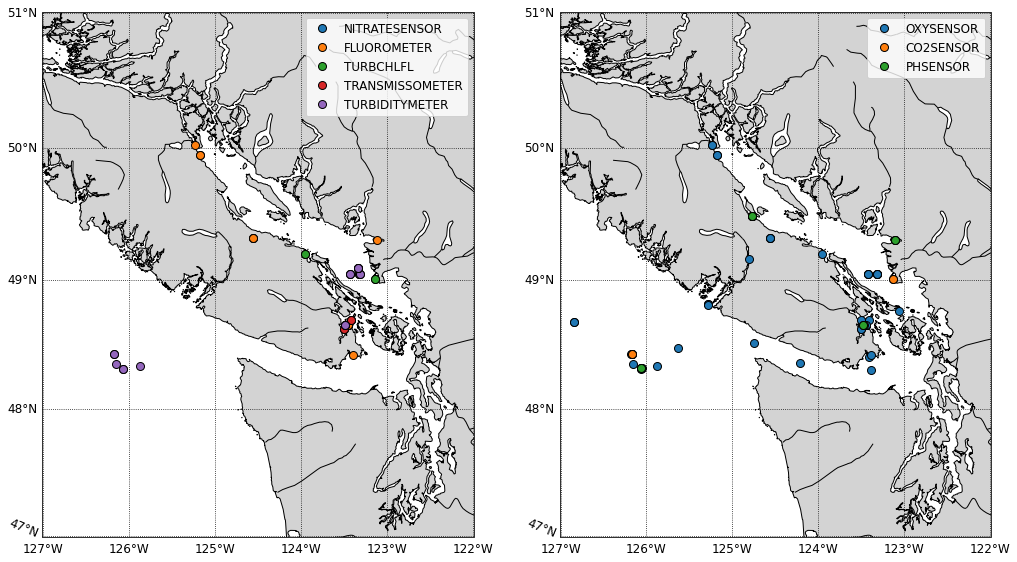

In [16]:
# Plot biological/chemical device platforms
fig, axs = plt.subplots(1, 2, figsize=(17, 10), subplot_kw={'projection': crs.Mercator()})
cmap = plt.get_cmap('tab10')
ncolors = cmap.N - 1
devices_list = [
    ['NITRATESENSOR', 'FLUOROMETER', 'TURBCHLFL', 'TRANSMISSOMETER', 'TURBIDITYMETER'],
    ['OXYSENSOR', 'CO2SENSOR', 'PHSENSOR'],
]
for ax, devices in zip(axs, devices_list):
    plot_map(ax)
    for k, device in enumerate(devices):
        plot_locations(device, color=palette(k/ncolors))
    ax.legend()